In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import sklearn
import yellowbrick
import re
import mglearn
import boto3
from s3 import get_file

/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
s3 = boto3.resource('s3')
lyrics = get_file(s3,'s3ssp',download_file='NLP_Data/master_lyrics_audio_features.csv',rename_file='nlp.csv')

In [3]:
df = pd.read_csv(lyrics,sep='|',encoding='utf-8')
df_demo = df.copy().dropna()

## Simulation of User Spotify Liked Library

In [132]:
X = df_demo.sample(5000)

In [133]:
def LDA_hyper_params(df):
    
    df_topic_rows = df.shape[0] #Dataframe Row count
    
    if(df_topic_rows in range(100,1000)):
        return {'max_features':100, 'n_components':3, 'n_words':10}
    
    elif(df_topic_rows in range(1001,4000)):
        return {'max_features':200, 'n_components' :5, 'n_words':10} 
        
    elif(df_topic_rows in range(4001,6000)):
        return {'max_features':10000, 'n_components' :15, 'n_words':10} 
    
    elif(df_topic_rows in range(6001,8000)):
        return {'max_features':400, 'n_components' :5, 'n_words':10} 
    
    elif(df_topic_rows in range(8001,10000)):
        return {'max_features':500, 'n_components' :5, 'n_words':10}
    
    elif(df_topic_rows >= 10000):
        return {'max_features':600, 'n_components' :5, 'n_words':10}
    else:
        return None

## Optimize max_features, n_components (used to be no_topics), n_words

In [134]:
#Control Panel - Hyper Parameters

hp = LDA_hyper_params(X)

#Count Vectorizer
#max_features = hp['max_features']
max_df = 1000
min_df = 4



#LDA
n_components = hp['n_components']  #10


#LDA Display
display_n_chunks = 5 #5
n_components = hp['n_components']        #20
n_words = hp['n_words']       #5


print(f'Max Features: {max_features} \nTopics: {n_components} \nWords: {n_words}')

Max Features: 10000 
Topics: 15 
Words: 10


## Top Word Count

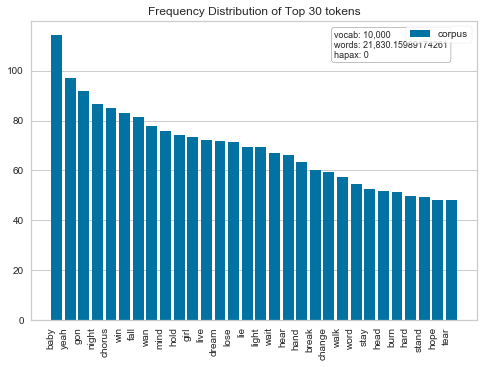

In [135]:
from sklearn.feature_extraction.text import CountVectorizer

from yellowbrick.text import FreqDistVisualizer

# Load the text data

vect = TfidfVectorizer(stop_words='english',max_df=max_df,max_features=max_features)

#vect = CountVectorizer(max_features=max_features, max_df=max_df,stop_words='english')
docs      = vect.fit_transform(X['lyrics'])
features   = vect.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v',n=30)
visualizer.fit(docs)
visualizer.show()

In [136]:
X2 = X.reset_index()

## Topic Analysis

In [138]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=n_components, learning_method="batch",
                                max_iter=10, random_state=0,doc_topic_prior=.2,topic_word_prior=4000)

# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once

#document_topics = lda_model.fit_transform(docs)

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=5,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(X2['lyrics'])

# Build LDA Model
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())


#print("lda.components_.shape: {}".format(lda.components_.shape))

# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda_model.components_, axis=1)#[:, ::-1]




# Get the feature names from the vectorizer
feature_names = np.array(vectorizer.get_feature_names())

# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(n_components), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words)





LatentDirichletAllocation(doc_topic_prior=0.2, n_components=15, random_state=0,
                          topic_word_prior=4000)
Log Likelihood:  -2471039.7658019545
Perplexity:  5860.066678157677
{'batch_size': 128, 'doc_topic_prior': 0.2, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 15, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 0, 'topic_word_prior': 4000, 'total_samples': 1000000.0, 'verbose': 0}
topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
lexus         lexus         lexus         macaroni      lexus         
macaroni      macaroni      macaroni      lettin        macaroni      
lettin        lettin        lettin        jacob         lettin        
jacob         jacob         jacob         claimin       jacob         
claimin       claimin    

Yo me encuentro solito
Si no te tengo a mi lado
Why ahora que no vivo
Porque sin ti me muero
Madre mia, madre mia
Madre mia, madre mia
Madre mia, madre mia
De mi alma
Madre mia mia de mi alma
No te vaya de mi vera
Porque sin ti no vivo
Muchas penas yo tengo
No vivo, no vivo
Madre mia, madre mia
Madre mia, madre mia
De mi alma

In [140]:
X2.iloc[0]

index                                                           80193
artist_name                                                     Auryn
track_name                                           grow old with me
track_uri                                      0iJLWzeJUzm7pYe8V3XSCT
acousticness                                                    0.722
danceability                                                    0.442
energy                                                          0.321
valence                                                         0.307
instrumentalness                                                    0
key                                                                 3
mode                                                                1
liveness                                                        0.106
speechiness                                                    0.0273
time_signature                                                      4
tempo               

In [142]:
lda_output
topicnames
len(docnames)

X2['track_uri'].iloc[2167]

'1JU1a1ELwtraZZDYmXExb5'

In [144]:
# Create Document - Topic Matrix

lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]


# index names
docnames = ["Doc" + str(i) for i in range(len(X2))]



# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)


df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .6 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .6 else 400
    return 'font-weight: {weight}'.format(weight=weight)


df_document_topic = df_document_topic['Topic3'].nlargest(n=20)
# Apply Style
#df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)


df_document_topic

Doc2167    0.93
Doc2569    0.93
Doc1576    0.91
Doc4104    0.90
Doc1291    0.88
Doc2351    0.88
Doc2832    0.88
Doc4323    0.86
Doc2612    0.82
Doc2707    0.81
Doc4205    0.78
Doc1898    0.76
Doc2688    0.73
Doc1845    0.72
Doc4353    0.71
Doc470     0.68
Doc431     0.56
Doc2419    0.41
Doc3049    0.40
Doc4605    0.36
Name: Topic3, dtype: float64

In [77]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

KeyError: 'dominant_topic'

In [145]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aah,abandon,abide,ability,ablaze,abortion,abrazo,absence,absent,absolute,...,youngin,youth,zeit,zie,ziel,zip,zone,zoo,zoom,zwei
Topic0,4000.131952,4000.002585,4000.002142,4000.000604,4000.000713,4000.000616,4000.001166,4000.000975,4000.000593,4000.000663,...,4000.000367,4000.005081,4000.328000,4000.306105,4000.135382,4000.000878,4000.002230,4000.001936,4000.000763,4000.001418
Topic1,4000.578749,4000.412517,4000.002142,4000.000606,4000.000711,4000.000615,4000.001166,4000.000976,4000.000590,4000.000663,...,4000.000367,4000.005069,4000.006278,4000.103386,4000.065081,4000.000878,4000.002231,4000.001937,4000.000765,4000.001418
Topic2,4000.000483,4000.002584,4000.002152,4000.000604,4000.000711,4000.000615,4002.405302,4000.000976,4000.000590,4000.000663,...,4000.000366,4000.005066,4001.214582,4000.117870,4000.117759,4000.000878,4000.002230,4000.001936,4000.000763,4000.849213
Topic3,4000.000483,4000.002587,4000.002145,4000.000604,4000.000711,4000.000618,4000.001166,4000.000977,4000.000592,4000.000663,...,4000.000366,4000.005064,4004.205437,4001.395611,4000.047245,4000.000879,4000.002237,4000.001937,4000.000763,4000.034553
Topic4,4000.000483,4000.212555,4000.002142,4000.000604,4000.000711,4000.000615,4000.073118,4000.000976,4000.000590,4000.000663,...,4000.000367,4000.005067,4001.287201,4004.191212,4000.000985,4000.000881,4000.002240,4000.001939,4000.000763,4000.001424


In [146]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,ser,quiero,amor,puede,homme,vida,amo,dam,pra,uma,casa,voy,voc,conmigo,mas
Topic 1,revolution,vida,boom,che,som,smell,nunca,wat,noche,mira,alma,siempre,amor,est,wil
Topic 2,ahora,ser,mal,vida,dam,amor,voy,solo,quiero,tan,influence,vez,siempre,allein,dia
Topic 3,mehr,che,voy,sole,mia,amor,ser,madre,vida,alma,sta,nie,van,dan,kono
Topic 4,che,amor,digo,sono,robert,tem,gente,ben,niet,het,hoy,quiero,jou,ser,male
Topic 5,conmigo,verdad,luz,alma,amor,quiero,quiere,voc,zeit,hoy,ser,vida,pra,welt,che
Topic 6,puede,goodbye,ser,che,ahora,quiero,nunca,solo,amor,dee,siempre,mas,est,tan,voy
Topic 7,ser,komm,tend,vida,amor,quiero,che,solo,arrive,mas,mal,steak,leben,kan,carolina
Topic 8,amor,che,mal,solo,quero,nunca,voc,willst,pra,dame,van,vida,ser,rio,bien
Topic 9,amor,aqu,boom,che,arriba,siento,mai,ser,bien,vida,puedo,dove,mas,amar,hoy


import numpy as np
from sklearn.manifold import TSNE
a = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(a)
X_embedded.shape

# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

## Assemble Playlist

In [147]:
def get_playlist_elements(components=range(n_components), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words):
    topics_words = []
    
    for i in range(0, len(components), topics_per_chunk):
        # for each chunk:
        these_topics = components[i: i + topics_per_chunk]
        
        for t in these_topics:
            
            topic_words = []
            
            for i in range(n_words):
                
                try:
                    #print(("{:<14}" * len_this_chunk).format(
                    #    *feature_names[sorting[these_topics, i]]))
                    topics_words.append({'topic':f'topic{t}','word':feature_names[sorting[these_topics, i]][t]})
                except:
                    pass
        
    return topics_words

In [148]:
playlist_elements = get_playlist_elements()

In [149]:
df_playlist_elements = pd.DataFrame(playlist_elements)

In [150]:
list_df_words = df_playlist_elements['word'].tolist()
list_df_topics = set(df_playlist_elements['topic'].tolist())

In [151]:
def find_lyrics(lyrics,element,track_uri):
    
    if(lyrics.find(element)!= -1):
        
        return track_uri
    
    else:
        
        return None


In [152]:
def make_ssp(topics,words):
    topics_words = df_playlist_elements.copy()
    
    df_lyrics = df_demo.copy()
    
    df_empty = pd.DataFrame()
    
    ssp = []
    
    #Set df_demo_ssp to topic number

    topics_words = topics_words[(topics_words['topic']== f'topic{topic}')]
    
    df_demo_ssp_wordset = topics_words['word'].tolist()

    for word in df_demo_ssp_wordset:
        
        df_empty[f'{word}'] = df_lyrics.apply(lambda x: find_lyrics(x['lyrics'],word,x['track_uri']),axis=1)



    return df_empty


## Takes 8 minutes

In [153]:
list_ssp = []

for topic in range(len(list_df_topics)):
    
    ssp = make_ssp(topic,list_df_words)

    
    df_ssp = ssp.dropna(how='all')
    
    for x in range(100):
        
        for col in df_ssp.columns:
            
            df_ssp_col = df_ssp[col].dropna(how='any')
            
            col_track_uri = df_ssp_col.sample(1).values
            
            list_ssp.append({'word':col,'playlist':f'topic{topic}playlist{x}','track_uri':col_track_uri[0]})


In [154]:
sample_ssp = pd.DataFrame(list_ssp)
df_track_ssp = sample_ssp.merge(df_demo,left_on='track_uri',right_on='track_uri')
df_agg_ssp = sample_ssp.merge(df_demo,left_on='track_uri',right_on='track_uri').groupby('playlist').median()

In [155]:
sample_ssp

,word,playlist,track_uri
0,lexus,topic0playlist0,6t8aRARnRaNwcY3rdF859F
1,macaroni,topic0playlist0,3qBxoudRLiLbFl7Ansz1Uh
2,lettin,topic0playlist0,5ksDTY4XsndnUqUDkndQk1
3,jacob,topic0playlist0,66GCLSYLNJCBSSCbKbmAie
4,claimin,topic0playlist0,6XkNBrBndPtFT19TS1WjVx
...,...,...,...
4995,ounce,topic4playlist99,6OSG8RAjlHTQfTI8IkT5XH
4996,prolly,topic4playlist99,0ylLlU1vW2dwuOnH3FYPvQ
4997,vip,topic4playlist99,3iYqbp7fOmdZPN5puwcnRM
4998,speakin,topic4playlist99,6nS6eSTUyaiXr4KSXosL56


In [156]:
ssp = df_track_ssp[df_track_ssp['playlist']=='topic0playlist1'].sort_values(by='valence',ascending=True)

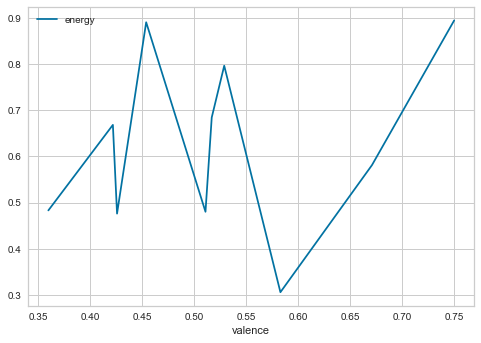

In [157]:
ssp.plot.line(x='valence',y='energy')

In [158]:
ssp['word'].values

array(['prolly', 'jacob', 'macaroni', 'vip', 'lexus', 'claimin',
       'fashioned', 'speakin', 'lettin', 'ounce'], dtype=object)

## Save SSP

In [159]:
#df_sample_ssp.to_csv('test_ssp.csv',sep='|',index=True)

## Below is Under Development

In [160]:
## Visualization (Valence Curve, Energy Curve)

In [161]:
## Create Spotify Playlist

In [162]:
import requests
import json
import pandas as pd
import spotipy#authentication
import spotipy.util as util#authentication
from spotipy.oauth2 import SpotifyClientCredentials#authentication

In [165]:
cid = '049ade7215e54c63a2b628f3784dc407'
secret = '171ef0fc408745e88dd5b99b83291146'
redirect_uri = 'http://google.com/'
username = 'name'

In [167]:
#Authentication

scope = 'playlist-modify-private'
token_playlist = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_playlist:
    
    sp_playlist = spotipy.Spotify(auth=token_playlist)

else:
    
    print("Can't get token for", username)
    
#Authentication

scope = 'user-read-private'

token_user = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_user:
    sp_user = spotipy.Spotify(auth=token_user)
else:
    print("Can't get token for", username)

Enter the URL you were redirected to: https://www.google.com/?code=AQCr8aNkCalk0mMHzrpB4Zhe-7Hk-ltXDUtqLnrOPA-9nIUqwJZgVQ6xdNS9jpWKeihX8anPp3bGKCTdTAhU_SyLwubZWJkODPlUfLkB-l_RIHNkCDFCITlonrdIF0Gwmpo8nV9w1W3ectz5noNGnK0vCxnJWh2Ua6R7ivieE3_2SBcY2a0awEcofhXlwHo
Enter the URL you were redirected to: https://www.google.com/?code=AQBXd1KlxHZ6-45wo8_Spmr7HK2hUG6BeDD5W7-UjUUeI_xumSBFdZsKwQdBbcAaxsalYmeT9trBkL_Q02Z_yMEaAL9NZjninR6yvLxrOq4rfcKRy99i_gY13Bk65bvYJuZUCMEoIj6xunJ7TZqeKziboyJjd9phDvQov1JLnhw0TBjP5J3eEEc


In [168]:
def get_user_id(url):
    try:
        resp = requests.get(url,headers={'Authorization': 'Bearer ' + token_user},
                             #data={"name": "SSP"}
                           )
        
        resp.raise_for_status()
        
    except requests.exceptions.HTTPError as err:
        
        print(err)
        
    
    response = resp.json()
    userid = response['id']
    
    return userid


In [169]:
user_id = get_user_id('https://api.spotify.com/v1/me')

In [170]:
identification = user_id
identification

'124399179'

In [171]:
playlist = sp_playlist.user_playlist_create(identification,str(ssp['word'].values), public=False, description="Ideal SSP")

In [172]:
playlist

{'collaborative': False,
 'description': 'Ideal SSP',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/3RHiXaDmA2btxclNiLXdaV'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/3RHiXaDmA2btxclNiLXdaV',
 'id': '3RHiXaDmA2btxclNiLXdaV',
 'images': [],
 'name': "['prolly' 'jacob' 'macaroni' 'vip' 'lexus' 'claimin' 'fashioned' 'speakin'\n 'lettin' 'ounce']",
 'owner': {'display_name': 'Adam Goldstein',
  'external_urls': {'spotify': 'https://open.spotify.com/user/124399179'},
  'href': 'https://api.spotify.com/v1/users/124399179',
  'id': '124399179',
  'type': 'user',
  'uri': 'spotify:user:124399179'},
 'primary_color': None,
 'public': False,
 'snapshot_id': 'MSw2ZTcwMDcyZTUxOWIwM2Q3N2ViODQ1NDg1OTY0OTMwMGE4ZDQwYzI3',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/3RHiXaDmA2btxclNiLXdaV/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri': '

In [173]:
playlist_tracks = sp_playlist.user_playlist_add_tracks(identification,playlist['id'],ssp['track_uri'], position=None)

## End

## Sample Topic Analysis Code

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {i}:".format(i=topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
#How many words per topic
no_top_words = 4
display_topics(nmf, tfidf_feature_names, no_top_words)